In [3]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
startdate="01/01/2015"
window_length = 10
encoding_dim = 3
epochs = 100
test_samples = 2000

In [12]:
def mkdate(ts):
    return datetime.datetime.fromtimestamp(
        int(ts)
    ).strftime('%Y-%m-%d')

def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 200))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    
df = pd.read_csv("amzn_cleaned", index_col = 'date', parse_dates = True)

df['pct_change'] = df.close.pct_change()
df['log_ret'] = np.log(df.close) - np.log(df.close.shift(1))
df = df.dropna()

scaler = MinMaxScaler()
x_train_nonscaled = np.array([df['log_ret'].values[i-window_length:i].reshape(-1, 1) for i in tqdm(range(window_length+1,len(df['log_ret'])))])
x_train = np.array([scaler.fit_transform(df['log_ret'].values[i-window_length:i].reshape(-1, 1)) for i in tqdm(range(window_length+1,len(df['log_ret'])))])

x_test = x_train[-test_samples:]
x_train = x_train[:-test_samples]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

100%|██████████| 5233/5233 [00:00<00:00, 5910.86it/s]


In [15]:
df

,close,volume,roc,rsi,tsi,bb_bbhi,bb_bbli,aroon_down,aroon,aroon_up,...,obv,vpt,fi,nvi,day_sin,day_cos,month_sin,month_cos,pct_change,log_ret
date,,,,,,,,,,,,,,,,,,,,,
2000-07-26,36.0625,15452.1,2.852050,40.134541,-15.064725,0.0,0.0,56.0,-52.0,4.0,...,-71994.0,-1447.166569,-3988.544957,632.201442,-0.743145,0.669131,-0.500000,-0.866025,-0.041528,-0.042415
2000-07-27,31.3750,23576.7,-5.283019,32.699086,-18.375261,0.0,1.0,100.0,-36.0,64.0,...,-95570.7,-3706.260897,-19206.721570,632.201442,-0.587785,0.809017,-0.500000,-0.866025,-0.129983,-0.139242
2000-07-28,30.0000,12444.2,-14.438503,30.891204,-21.659706,0.0,1.0,100.0,-40.0,60.0,...,-108014.9,-3609.925738,-18907.300632,604.495403,-0.406737,0.913545,-0.500000,-0.866025,-0.043825,-0.044814
2000-07-31,30.1250,9478.4,-13.928571,31.263266,-24.163073,0.0,0.0,96.0,-40.0,56.0,...,-98536.5,-505.870013,-16037.000541,607.014133,0.207912,0.978148,-0.500000,-0.866025,0.004167,0.004158
2000-08-01,30.2500,8140.8,-28.823529,31.659494,-26.085806,0.0,0.0,92.0,-40.0,52.0,...,-90395.7,73.272586,-13600.629035,609.532864,0.207912,0.978148,-0.866025,-0.500000,0.004149,0.004141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,3244.9900,2422.8,-1.856417,48.172664,-6.814223,0.0,0.0,68.0,-36.0,32.0,...,1505136.7,-24.671503,-23573.005285,670.966455,-0.951057,0.309017,0.500000,-0.866025,0.013084,0.012999
2021-05-25,3259.0500,3261.1,-0.989182,49.577056,-6.018646,0.0,0.0,64.0,-36.0,28.0,...,1508397.8,45.830399,-13655.280816,670.966455,-0.866025,0.500000,0.500000,-0.866025,0.004333,0.004323
2021-05-26,3265.1600,2384.0,2.340393,50.208486,-5.186664,0.0,0.0,60.0,-36.0,24.0,...,1510781.8,18.599276,-9623.634985,672.224369,-0.743145,0.669131,0.500000,-0.866025,0.001875,0.001873


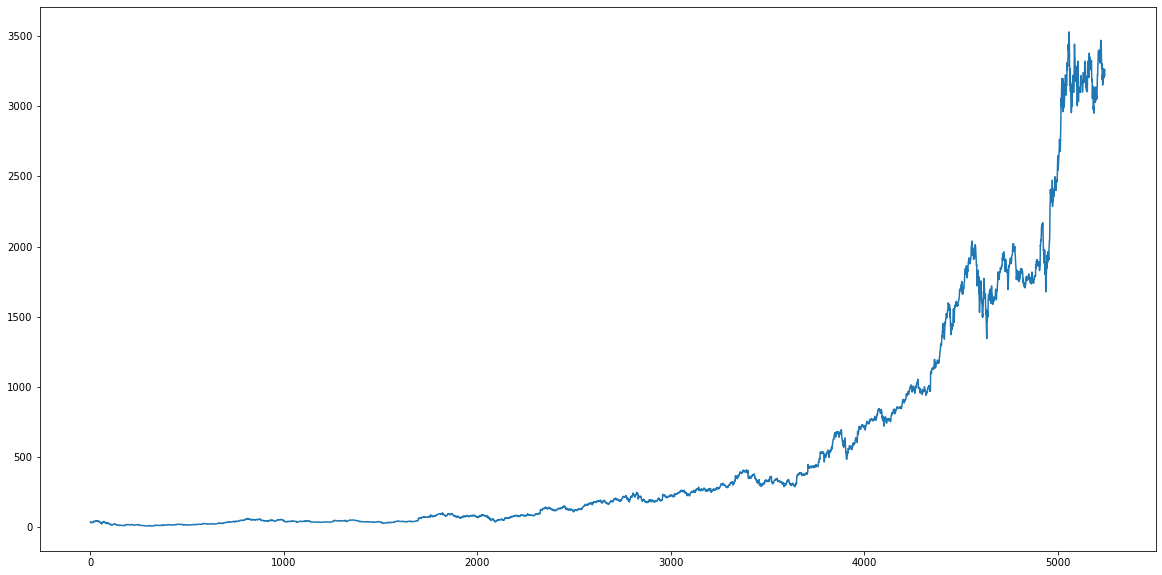

In [14]:
plt.figure(figsize=(20,10))
plt.plot(np.array(df.close))

In [16]:
print("Percentage of test data: {}%".format((test_samples/len(x_train))*100))

Percentage of test data: 61.862047633776676%


In [17]:
x_train_simple = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))
encoded = Dense(encoding_dim, activation='relu')(input_window)
decoded = Dense(window_length, activation='sigmoid')(encoded)
autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 33        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 21s 258ms/step - loss: 0.7415 - val_loss: 0.7421
Epoch 2/100
4/4 [==============================] - 0s 21ms/step - loss: 0.7387 - val_loss: 0.7391
Epoch 3/100
4/4 [==============================] - 0s 19ms/step - loss: 0.7370 - val_loss: 0.7363
Epoch 4/100
4/4 [==============================] - 0s 20ms/step - loss: 0.7339 - val_loss: 0.7336
E

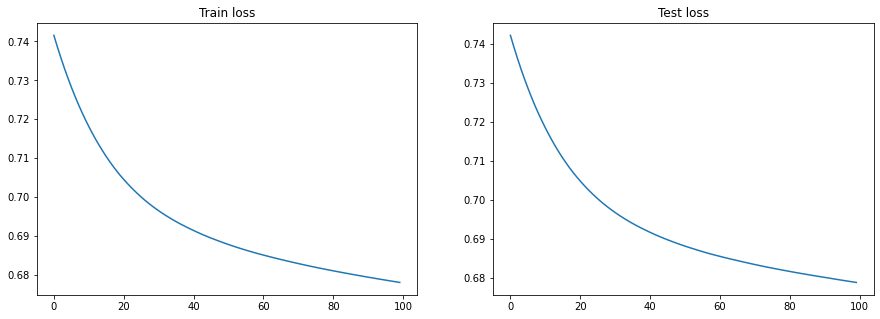

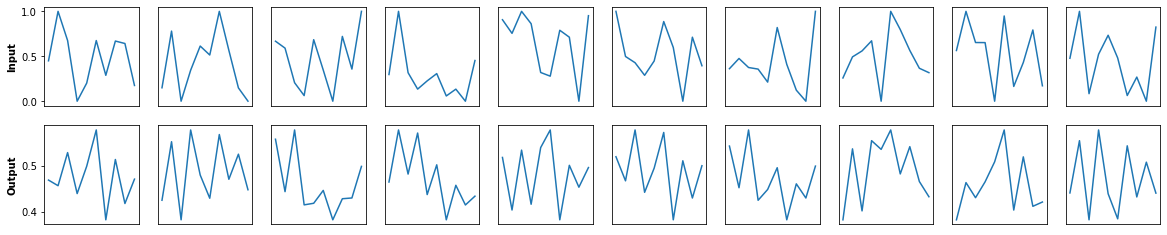

In [18]:
plot_history(history)
plot_examples(x_test_simple, decoded_stocks)

In [19]:
x_train_deep = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 66        
_________________________________________________________________
batch_normalization (BatchNo (None, 6)                 24        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 24        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                70  

4/4 [==============================] - 0s 17ms/step - loss: 0.6434 - val_loss: 0.6578
Epoch 72/100
4/4 [==============================] - 0s 36ms/step - loss: 0.6429 - val_loss: 0.6569
Epoch 73/100
4/4 [==============================] - 0s 33ms/step - loss: 0.6421 - val_loss: 0.6561
Epoch 74/100
4/4 [==============================] - 0s 23ms/step - loss: 0.6416 - val_loss: 0.6552
Epoch 75/100
4/4 [==============================] - 0s 23ms/step - loss: 0.6410 - val_loss: 0.6543
Epoch 76/100
4/4 [==============================] - 0s 22ms/step - loss: 0.6408 - val_loss: 0.6534
Epoch 77/100
4/4 [==============================] - 0s 33ms/step - loss: 0.6396 - val_loss: 0.6526
Epoch 78/100
4/4 [==============================] - 0s 33ms/step - loss: 0.6390 - val_loss: 0.6518
Epoch 79/100
4/4 [==============================] - 0s 23ms/step - loss: 0.6381 - val_loss: 0.6510
Epoch 80/100
4/4 [==============================] - 0s 38ms/step - loss: 0.6384 - val_loss: 0.6502
Epoch 81/100
4/4 [=====

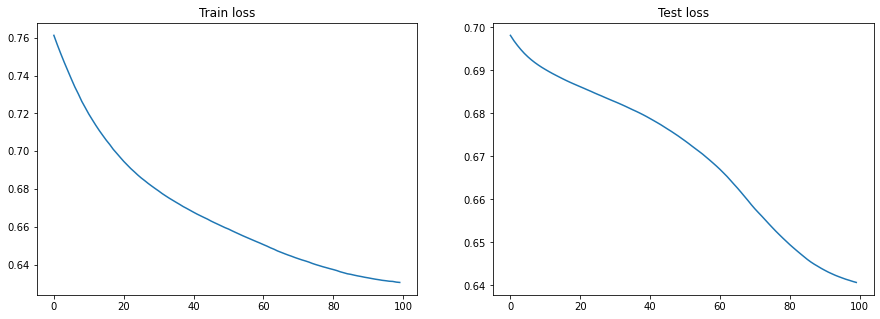

In [20]:
plot_history(history)

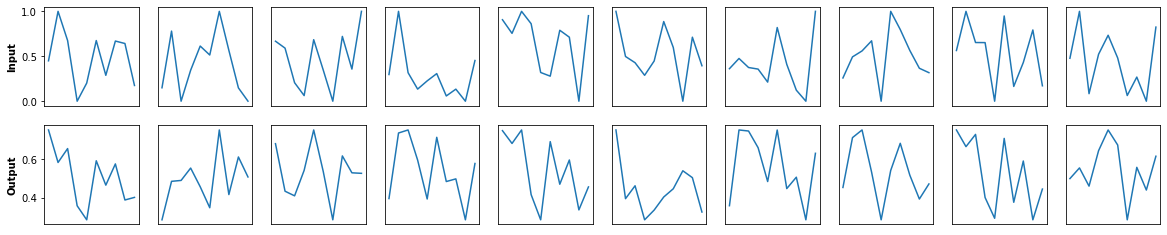

In [21]:
plot_examples(x_test_deep, decoded_stocks)

In [22]:
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 10, 16)            64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 1)              49        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 1)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 1)              4         
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 6, 1)              0   

4/4 [==============================] - 0s 45ms/step - loss: 0.6544 - val_loss: 0.6560
Epoch 68/100
4/4 [==============================] - 0s 52ms/step - loss: 0.6539 - val_loss: 0.6559
Epoch 69/100
4/4 [==============================] - 0s 39ms/step - loss: 0.6539 - val_loss: 0.6558
Epoch 70/100
4/4 [==============================] - 0s 39ms/step - loss: 0.6539 - val_loss: 0.6557
Epoch 71/100
4/4 [==============================] - 0s 49ms/step - loss: 0.6541 - val_loss: 0.6556
Epoch 72/100
4/4 [==============================] - 0s 46ms/step - loss: 0.6535 - val_loss: 0.6556
Epoch 73/100
4/4 [==============================] - 0s 40ms/step - loss: 0.6539 - val_loss: 0.6555
Epoch 74/100
4/4 [==============================] - 0s 47ms/step - loss: 0.6534 - val_loss: 0.6554
Epoch 75/100
4/4 [==============================] - 0s 42ms/step - loss: 0.6537 - val_loss: 0.6553
Epoch 76/100
4/4 [==============================] - 0s 42ms/step - loss: 0.6535 - val_loss: 0.6552
Epoch 77/100
4/4 [=====

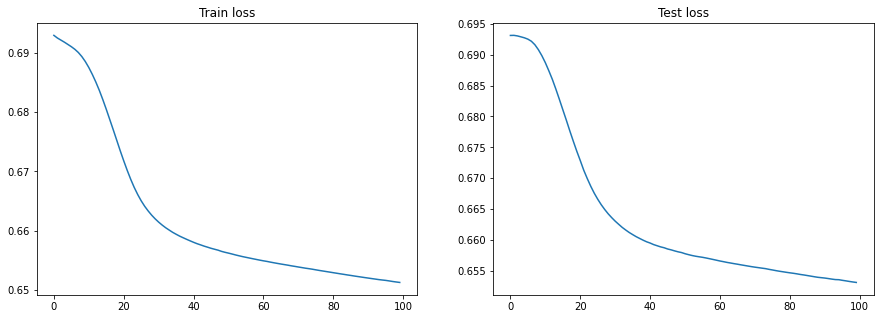

In [23]:
plot_history(history)

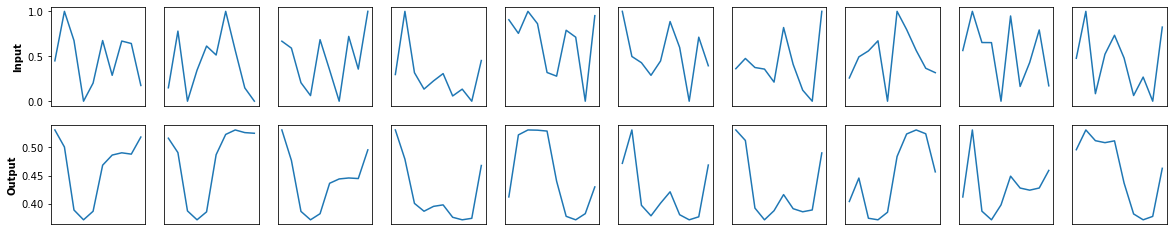

In [24]:
plot_examples(x_test_deep, decoded_stocks)

In [25]:
inputs = Input(shape=(window_length, 1))
encoded = LSTM(encoding_dim)(inputs)

decoded = RepeatVector(window_length)(encoded)
decoded = LSTM(1, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder.summary()

sequence_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = sequence_autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = sequence_autoencoder.predict(x_test)


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 3)                 60        
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 3)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 1)             20        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 14s 595ms/step - loss: 1.4923 - val_loss: 1.4744
Epoch 2/100
4/4 [==============================] - 0s 45ms/step - loss: 1.4269 - val_loss: 1.4172
Epoch 3/100
4/4 [==============================] - 0s 36ms/step

Epoch 75/100
4/4 [==============================] - 0s 44ms/step - loss: 0.7041 - val_loss: 0.7075
Epoch 76/100
4/4 [==============================] - 0s 53ms/step - loss: 0.7029 - val_loss: 0.7072
Epoch 77/100
4/4 [==============================] - 0s 46ms/step - loss: 0.7022 - val_loss: 0.7069
Epoch 78/100
4/4 [==============================] - 0s 51ms/step - loss: 0.7028 - val_loss: 0.7066
Epoch 79/100
4/4 [==============================] - 0s 50ms/step - loss: 0.7030 - val_loss: 0.7063
Epoch 80/100
4/4 [==============================] - 0s 57ms/step - loss: 0.7025 - val_loss: 0.7060
Epoch 81/100
4/4 [==============================] - 0s 49ms/step - loss: 0.7015 - val_loss: 0.7057
Epoch 82/100
4/4 [==============================] - 0s 46ms/step - loss: 0.7014 - val_loss: 0.7054
Epoch 83/100
4/4 [==============================] - 0s 63ms/step - loss: 0.7023 - val_loss: 0.7051
Epoch 84/100
4/4 [==============================] - 0s 67ms/step - loss: 0.7009 - val_loss: 0.7048
Epoch 85/1

In [26]:
synthesized = []
required_nums = [0, 1]
optional_nums = list(np.arange(0.1, 0.9, 0.1))
for i in tqdm(range(100000)):
    combo = list(np.random.choice(optional_nums, 8))+required_nums
    np.random.shuffle(combo)
    synthesized.append(combo)

100%|██████████| 100000/100000 [00:06<00:00, 15000.18it/s]


In [27]:
x_train_simple = np.concatenate((x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))),synthesized))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


input_window = Input(shape=(window_length,))
encoded = Dense(encoding_dim, activation='relu')(input_window)
decoded = Dense(window_length, activation='sigmoid')(encoded)
autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_7 (Dense)              (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
101/101 [==============================] - 3s 8ms/step - loss: 0.7053 - val_loss: 0.6912
Epoch 2/100
101/101 [==============================] - 0s 4ms/step - loss: 0.6879 - val_loss: 0.6792
Epoch 3/100
101/101 [==============================] - 0s 3ms/step - loss: 0.6755 - val_loss: 0.6700
Epoch 4/100
101/101 [==============================] - 0s 4ms/step - loss: 0.6659 - val_lo

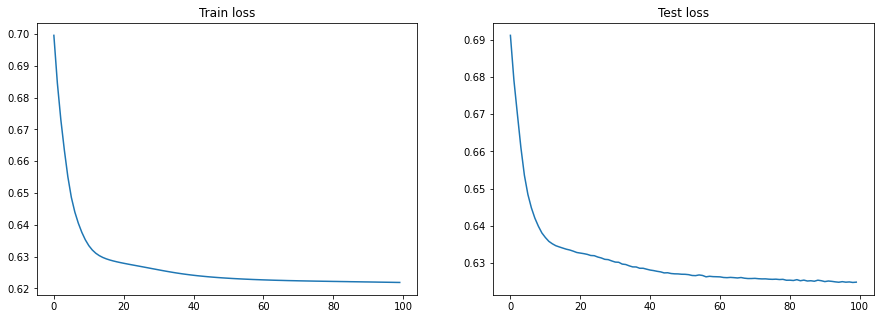

In [28]:
plot_history(history)

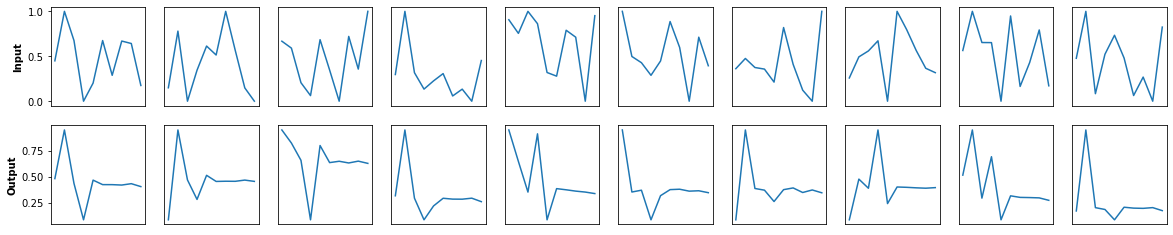

In [29]:
plot_examples(x_test_simple, decoded_stocks)

In [30]:
x_train_deep = np.concatenate((x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))),synthesized))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)
autoencoder = Model(input_window, decoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 66        
_________________________________________________________________
batch_normalization_2 (Batch (None, 6)                 24        
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 24        
_________________________________________________________________
batch_normalization_3 (Batch (None, 6)                 24        
_________________________________________________________________
dense_11 (Dense)             (None, 10)                70 

Epoch 69/100
101/101 [==============================] - 0s 5ms/step - loss: 0.6215 - val_loss: 0.6233
Epoch 70/100
101/101 [==============================] - 0s 5ms/step - loss: 0.6213 - val_loss: 0.6238
Epoch 71/100
101/101 [==============================] - 0s 4ms/step - loss: 0.6214 - val_loss: 0.6240
Epoch 72/100
101/101 [==============================] - 0s 4ms/step - loss: 0.6214 - val_loss: 0.6242
Epoch 73/100
101/101 [==============================] - 0s 4ms/step - loss: 0.6212 - val_loss: 0.6237
Epoch 74/100
101/101 [==============================] - 0s 4ms/step - loss: 0.6213 - val_loss: 0.6236
Epoch 75/100
101/101 [==============================] - 0s 5ms/step - loss: 0.6210 - val_loss: 0.6234
Epoch 76/100
101/101 [==============================] - 0s 4ms/step - loss: 0.6211 - val_loss: 0.6234
Epoch 77/100
101/101 [==============================] - 0s 4ms/step - loss: 0.6214 - val_loss: 0.6240
Epoch 78/100
101/101 [==============================] - 0s 4ms/step - loss: 0.6214

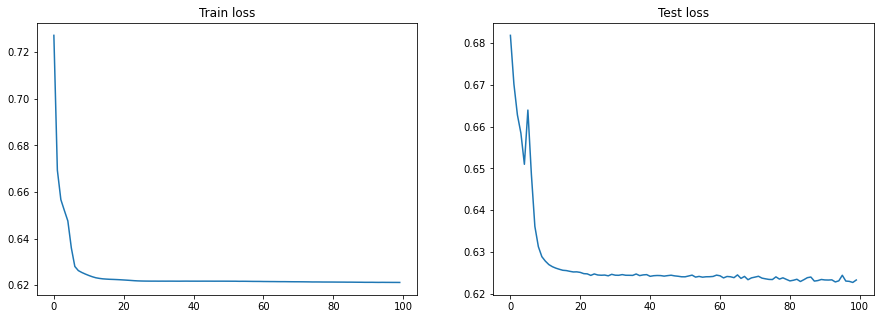

In [31]:
plot_history(history)

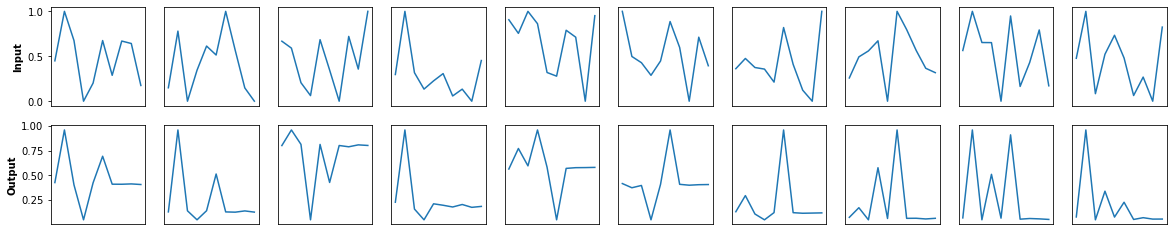

In [32]:
plot_examples(x_test_simple, decoded_stocks)